# (NSERC) HTML Data into a DataFrame

This notebook is a quick example on turning HTML data into a DataFrame. Ideally we would use pd.read_html, but there are some messy XML dependencies that way. The code below simply makes a request for the data, splits it up using Beautiful Soup and then builds some lists that we can turn into a DataFrame.

HTML can be frustratingly imprecise and error ridden, but beautiful soup can be convinced to handle most of these idiosyncrasies. Happily though the NSERC pages used below as an example seem to be reasonably well formed.

> This notebook was initially built as part of the PIMS exploration of Jupyter notebooks during Summer 2016. I'm grateful for input from Ian Allison, Andrew Cote, Eric Easthope and Ricky Hu. --J. Colliander

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

In [3]:
def getNSERCGrants(year=2016,group=1508):
    """
    Here you are looking for some way to uniquely identify the object 
    we are interested in. In this case our table is wrapped in a div 
    with `class="DataTable2"`
    
    Keyword arguments:
    year -- The year for which to extract data 2012 <= year <= 2016
    group - the NSERC evaluation group, 19, and 1501 thru 1512. 
       (Note RTI's also available, labeled 1601 thru 1609, skips 06, 08.)
    
    Returns:
       pandas.DataFrame: The data for that year
    """
    
    # GSC=1508 is the "Evaluation Group" for Math, other groups are
    # available but differ year-by-year. It might be nice to make
    # these things selectable as widgets.
    r  = requests.get("http://www.nserc-crsng.gc.ca/NSERC-CRSNG/" + 
                  "FundingDecisions-DecisionsFinancement/" +
                  "ResearchGrants-SubventionsDeRecherche/" +
                  "ResultsGSCDetail-ResultatsCSSDetails_eng.asp?Year=" +
                  str(year) + "&GSC=" + str(group))
    

    #soup = BeautifulSoup(r.text, "html5lib")
    soup = BeautifulSoup(r.text, "html.parser")

    table = soup.find('div', attrs={'class':'DataTable2'})
    table_body = table.find('tbody')
    
    # Pick out the headings first
    headings = [th.get_text() for th in table.find("tr").find_all("th")]
    
    datasets = []
    for row in table.find_all("tr")[1:]:
        dataset = [td.get_text() for td in row.find_all("td")]
        datasets.append(dataset)
        
    data = pd.DataFrame(datasets, columns=headings)
    data['Awarded Amount'] = data['Awarded Amount'].map(
        lambda x: np.float(x.lstrip('$').replace(',','')))
    return data

In [4]:
NSERCdf = getNSERCGrants()
NSERCdf.head()

,Applicant Name,Institution,Program,Title,Term,Awarded Amount
0,"Abrahamowicz, MichalDepartmentEpidemiology, Bi...",McGill,RGPIN,Flexible statistical models for dynamic predic...,1,20000.0
1,"Agueh, MartialDepartmentMathematics and Statis...",Victoria,RGPIN,"Kinetic granular media, Wasserstein barycenter...",5,20000.0
2,"Akbary, AmirDepartmentMathematics and Computer...",Lethbridge,RGPIN,Elliptic Curves and L-functions,5,16000.0
3,"Assem, IbrahimDepartmentMathématiques - Mathém...",Université de Sherbrooke,RGPIN,Représentations des algèbres et algèbres amassées,5,25000.0
4,"Bailey, RobertDepartmentGrenfell Campus - Gren...",Memorial Univ. of Nfld,RGPIN,"Graphs, Designs, Codes and Groups: Topics in A...",5,17000.0


## Bulk collection

Now we'll loop over years and evaluation groups, and collect some more data.

In [5]:
years = [2012, 2013, 2014, 2015, 2016]
groups = [19, 1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512]
groups_no19 = [1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512]

In [6]:
NSERCcsv = "./NSERCAllDF.csv"
cachedData = True

if os.path.isfile(NSERCcsv) and cachedData:
    print("USING CACHED DATA!!!!!!")
    NSERCAllDF = pd.read_csv(NSERCcsv)
else:
    NSERCAnnualDF = {(year,group) : getNSERCGrants(year,group) for year in years for group in groups}
    NSERCAllDF = pd.DataFrame(
    pd.concat(NSERCAnnualDF, names=['Year','Group']).to_records())
#    NSERCAllDF = NSERCAllDF.drop('id', 1)

# Drop the extra index
NSERCAllDF.head()

USING CACHED DATA!!!!!!


,Unnamed: 0,Year,Group,level_0,Applicant Name,Institution,Program,Title,Term,Awarded Amount
0,0,2012,19,0,"Andreoiu, Corina CDepartmentChemistry",Simon Fraser,SAPPJ,Precision Electron Capture Branching Ratio Mea...,3,160000.0
1,1,2012,19,1,"Austin, Roby RAEDepartmentAstronomy and Physics",Saint Mary's,SAPIN,Single-nucleon effects revealed through gamma-...,1,15000.0
2,2,2012,19,2,"Baartman, Richard ADepartmentAccelerator Techn...",TRIUMF,SAPPJ,Cyclotron Physics,3,15000.0
3,3,2012,19,3,"Barkanova, Svetlana SDepartmentPhysics",Acadia,SAPIN,Electroweak Radiative Effects and Hadronic Str...,5,20000.0
4,4,2012,19,4,"Behr, John JADepartmentScience Division",TRIUMF,SAPPJ,TRIUMF neutral atom trap for beta decay studies,3,143000.0


In [63]:
a = NSERCAllDF[NSERCAllDF.Year == 2016]

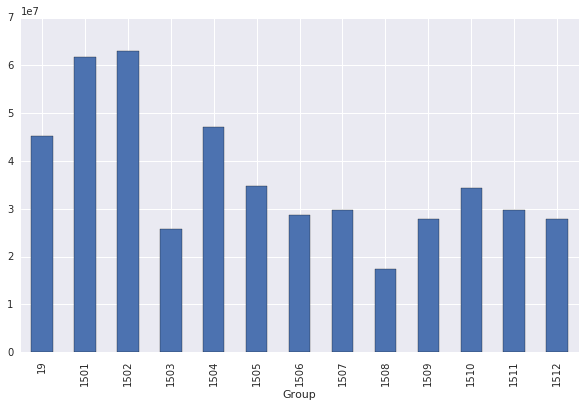

In [7]:
NSERCAllDF.groupby('Group')['Awarded Amount'].sum().plot.bar()


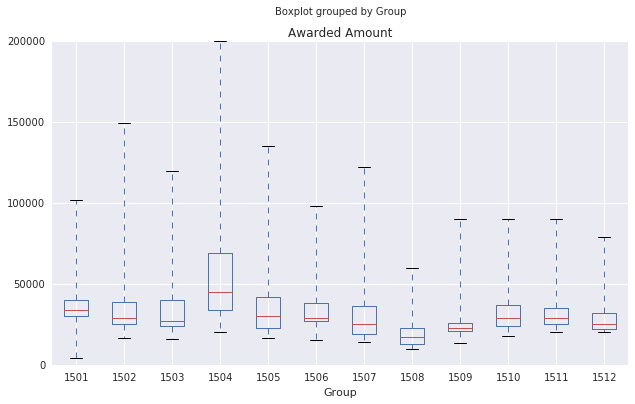

In [8]:
# Look at all the research grants only, no equipment
NSERCAllDF[NSERCAllDF.Program == 'RGPIN'].boxplot(column='Awarded Amount', by='Group', whis=1000)

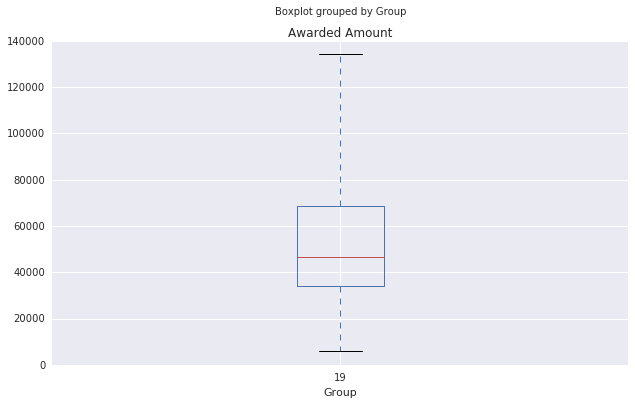

In [9]:
# Darn it, Subatomic physics gets left out, as they use a different code for their grants
NSERCAllDF[NSERCAllDF.Program == 'SAPIN'].boxplot(column='Awarded Amount', by='Group', whis=1000)

In [10]:
NSERCAllDF.to_csv(NSERCcsv)

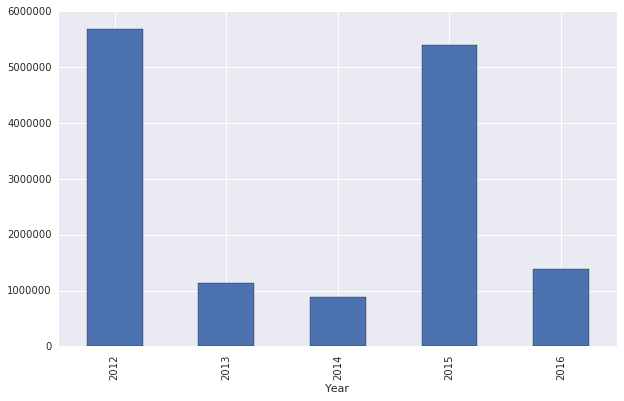

In [11]:
NSERCAllDF.groupby('Year')['Awarded Amount'].max().plot.bar()

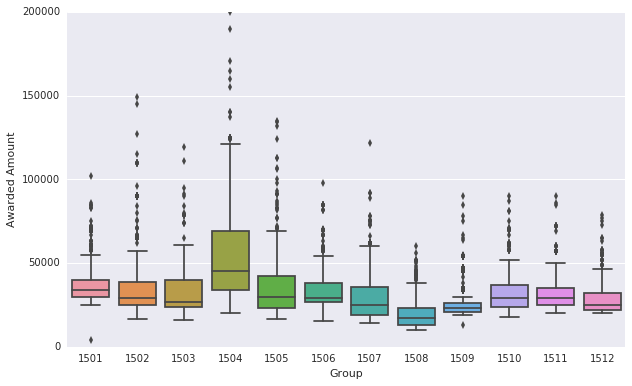

In [12]:
# Here is a plot of individual research grants, by discipline. The lowest (1508) is math/stat
NSERC_RGPIN = NSERCAllDF[NSERCAllDF.Program == 'RGPIN']
ax = sns.boxplot(x=NSERC_RGPIN['Group'], y=NSERC_RGPIN['Awarded Amount'])

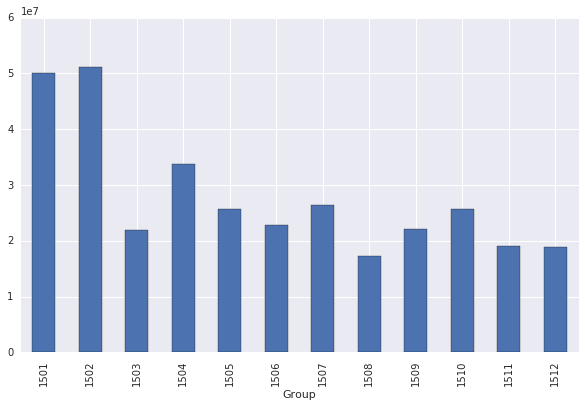

In [13]:
# Here is the total amount distributed over 5 years to each discipline. Reseach grants only (no EQP)
# But again, Supatomic physics doesn't show up as it uses a different code.
NSERC_RGPIN.groupby('Group')['Awarded Amount'].sum().plot.bar()

In [14]:
# The really big research grants are in Chemistry (group 1504)
NSERC_RGPIN[NSERC_RGPIN['Awarded Amount'] > 150000]

,Unnamed: 0,Year,Group,level_0,Applicant Name,Institution,Program,Title,Term,Awarded Amount
1013,1013,2012,1504,129,"Winnik, Mitchell MADepartmentChemistry",Toronto,RGPIN,"Polymer conformation, Dynamics, and Morphology",5,171000.0
3443,3443,2013,1504,115,"Scaiano, Juan Cesar JCDepartmentChemistry",Ottawa,RGPIN,Physical organic chemistry in nanotechnology a...,5,200000.0
3474,3474,2013,1504,146,"Withers, Stephen GDepartmentChemistry",British Columbia,RGPIN,Interactions and Reactions of Carbohydrates an...,5,160000.0
5640,5640,2014,1504,28,"Charette, AndréDepartmentChimie",Université de Montréal,RGPIN,New Methods for the Stereoselective Synthesis ...,5,165000.0
5716,5716,2014,1504,104,"Polanyi, JohnDepartmentChemistry",Toronto,RGPIN,"Reaction Dynamics At Surfaces, A-Molecule-At-A...",5,190000.0
5735,5735,2014,1504,123,"Stephan, DouglasDepartmentChemistry",Toronto,RGPIN,Frustrated Lewis Pairs: Metal-Free Synthesis a...,5,155000.0


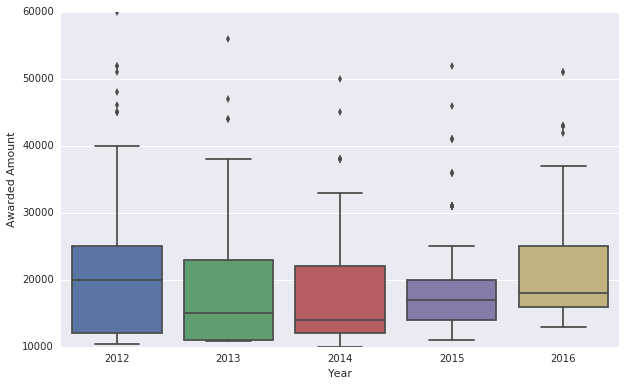

In [15]:
# Let's look at math grants
MATHONLY = NSERCAllDF[NSERCAllDF.Group == 1508]
ax = sns.boxplot(x=MATHONLY['Year'], y=MATHONLY['Awarded Amount'])

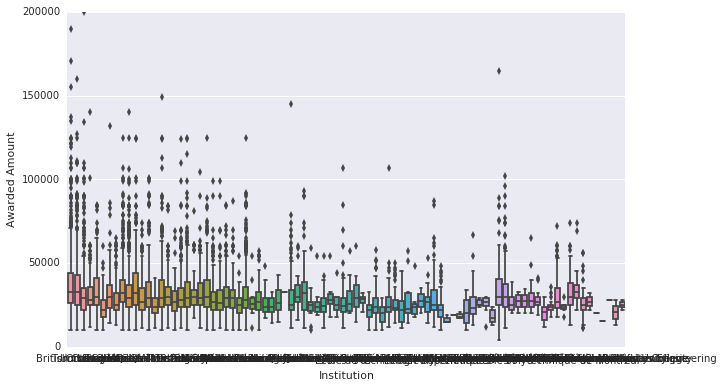

In [16]:
ax = sns.boxplot(x=NSERC_RGPIN['Institution'], y=NSERC_RGPIN['Awarded Amount'])

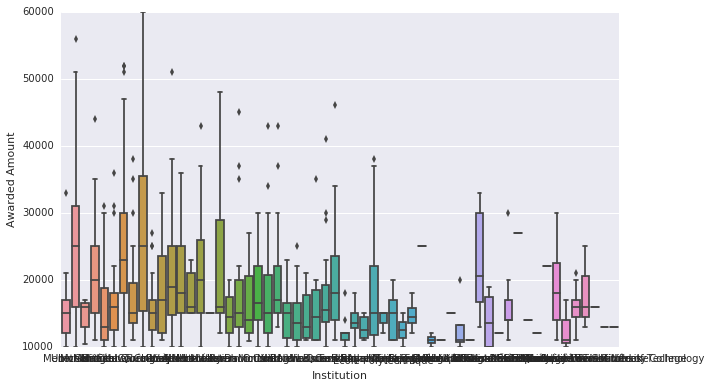

In [17]:
ax = sns.boxplot(x=MATHONLY['Institution'], y=MATHONLY['Awarded Amount'])